In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import os
from config.config import LSTM_DATA_DIR, LSTM_MODELS_DIR, LSTM_CALIBRATED_DIR, SWAT_PREDICTIONS_DIR, OBSERVACIONS_DIR, OBSERVACIONS_FILTRAT_DIR
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import keras_tuner as kt
import joblib
from tensorflow.keras.layers import Dropout


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
scaler = joblib.load(LSTM_CALIBRATED_DIR / 'lstm_scaler_5.pkl')
model = keras.models.load_model(LSTM_CALIBRATED_DIR / 'lstm_hypermodel_5.h5')

In [5]:

merged_train_all_stations = []
merged_val_all_stations = []

n_input = 150
n_features = 18
#n_features = 3

#get all the files in the directory
files = os.listdir(LSTM_DATA_DIR)

#read all the files that are csv
for file in files:
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(LSTM_DATA_DIR / file))


        #convert datetime to timestamp and make it the index
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.set_index('datetime')

        
        #split between tain, validation and test
        n = len(df)
        train_df = df[0:int(n*0.85)]
        val_df = df[int(n*0.85):]


        #Create the generator
        #X_train = train_df.values
        #X_train = train_df[['Flow', 'precipitation', 'temperature']].values
        X_train = train_df.drop(columns=['Flow']).values
        y_train = train_df['Flow'].values
        
        #X_val = val_df.values
        #X_val = val_df[['Flow', 'precipitation', 'temperature']].values
        X_val = val_df.drop(columns=['Flow']).values
        y_val = val_df['Flow'].values



        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)


        train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=1)
        val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=1)


        #Get [([info day 1, ..., info day n], flow observation)]
        merged_train = [(sample[0][0], sample[1][0]) for sample in train_generator]
        merged_val = [(sample[0][0], sample[1][0]) for sample in val_generator]


        merged_train_all_stations.extend(merged_train)
        merged_val_all_stations.extend(merged_val)



In [6]:
#shuffle the data
#np.random.shuffle(merged_train_all_stations)
#np.random.shuffle(merged_val_all_stations)

X_train, y_train = zip(*merged_train_all_stations)
X_val, y_val = zip(*merged_val_all_stations)


X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)


In [7]:
model1 = Sequential()


for layer in model.layers[:-1]:
    model1.add(layer)


# Freeze all the layers of base model
for layer in model.layers:
    layer.trainable=False
 
# adding new layers
#model1.add(Dense(50,input_dim=1))
model1.add(Dense(1, activation='relu'))

model1.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(), optimizer='adam')
#model1.compile(loss='mae', optimizer='adam')


In [8]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)


In [9]:
history = model1.fit(X_train, y_train, epochs=30, validation_data = (X_val, y_val), callbacks=[stop_early])


Epoch 1/30
6862/6862 [==============================] - 51s 7ms/step - loss: 0.2372 - val_loss: 0.2697
Epoch 2/30
6862/6862 [==============================] - 48s 7ms/step - loss: 0.2050 - val_loss: 0.2659
Epoch 3/30
6862/6862 [==============================] - 47s 7ms/step - loss: 0.2033 - val_loss: 0.2608
Epoch 4/30
6862/6862 [==============================] - 48s 7ms/step - loss: 0.2030 - val_loss: 0.2587
Epoch 5/30
6862/6862 [==============================] - 48s 7ms/step - loss: 0.2027 - val_loss: 0.2660
Epoch 6/30
6862/6862 [==============================] - 47s 7ms/step - loss: 0.2031 - val_loss: 0.2636
Epoch 7/30
6862/6862 [==============================] - 47s 7ms/step - loss: 0.2029 - val_loss: 0.2601
Epoch 8/30
6862/6862 [==============================] - 47s 7ms/step - loss: 0.2028 - val_loss: 0.2616


In [10]:
#store model
model1.save(LSTM_CALIBRATED_DIR / 'lstm_transfer_learning.h5')

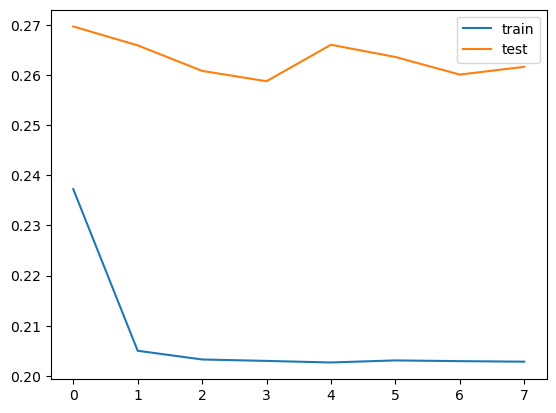

In [11]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()